In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas to show all columns for easier inspection
pd.set_option('display.max_columns', None)

Libraries loaded. Ready for analysis.


In [2]:
def clean_arkadian_data(df, year_label):
    print(f"Cleaning {year_label} data...")
    
    # 1 - Standard Sector Labels (The "Big 6")
    sector_labels = {
        '45': 'Construction', '72': 'IT & Computer Services', 
        '79': 'Consulting & Business', '85': 'Health & Social Work', 
        '35': 'Security & Defense', '60': 'Transport'
    }
    
    # Create Sector Columns
    df['sector_code'] = df['tender_classification_id'].astype(str).str[:2]
    df['industry_label'] = df['sector_code'].map(sector_labels).fillna('Other')
    
    # One-Hot Encode (Create the 'is_Construction' etc. columns)
    dummies = pd.get_dummies(df['industry_label'], prefix='is')
    df = df.join(dummies)

    # 2 - Engineering the Behavioural Flags
    # SME Flag (If missing, fill 0)
    if 'tender_suitability_sme' in df.columns:
        df['sme_flag'] = df['tender_suitability_sme'].map({True: 1, False: 0}).fillna(0)
    else:
        df['sme_flag'] = 0
        
    # Accelerated Flag
    if 'tender_procedure_isAccelerated' in df.columns:
        df['accelerated_flag'] = df['tender_procedure_isAccelerated'].map({True: 1, False: 0}).fillna(0)
    else:
        df['accelerated_flag'] = 0

    # 3 - Calculate Lead Time (The #1 Predictor from Loadings)
    # Start Date - Publication Date
    df['lead_time_days'] = (pd.to_datetime(df['tender_contractPeriod_startDate'], utc=True) - 
                            pd.to_datetime(df['date'], utc=True)).dt.days.fillna(0)
    
    # 4 - Define the Target (Risk = 1)
    # We include Cancelled, Unsuccessful and Withdrawn. 
    df['Risk_Label'] = df['tender_status'].apply(
        lambda x: 1 if x in ['cancelled', 'unsuccessful', 'withdrawn'] else 0
    )
    
    return df

Cleaning Engine loaded.


In [3]:
# 1. Load the raw files
raw_21 = pd.read_excel("UK2021Risk.J.xlsx")

In [4]:
raw_22 = pd.read_excel("UK2022Risk.J.xlsx")

In [5]:
raw_23 = pd.read_excel("UK2023Risk.J.xlsx")

In [6]:
raw_24 = pd.read_excel("UK2024Risk.J.xlsx")

In [7]:
# 2 - Apply the cleaning thing
df_21 = clean_arkadian_data(raw_21, "2021")
df_22 = clean_arkadian_data(raw_22, "2022")
df_23 = clean_arkadian_data(raw_23, "2023")
df_24 = clean_arkadian_data(raw_24, "2024")

Cleaning 2021 data...
Cleaning 2022 data...
Cleaning 2023 data...
Cleaning 2024 data...


In [8]:
# --- BUYER RISK ENGINE (GRID SEARCH) ---

# 1 - Setup History (Training) vs Future (Validation)
# We use 22/23 to learn the reputation, and 24 to test which 'k' predicts best
history_df = pd.concat([df_22, df_23], ignore_index=True)      # <--- can put '21 here too if inc.
validation_df = df_24.copy()

print(f"Buyer Risk Engine: Learning from {len(history_df)} past contracts...")

# 2 - Helper to extract purely the failure signal for calculation
def get_binary_target(df):
    fail_statuses = ['cancelled', 'unsuccessful', 'withdrawn']
    temp = pd.DataFrame()
    temp['clean_id'] = df['buyer_id'].astype(str).str.strip()
    temp['is_failure'] = df['tender_status'].isin(fail_statuses).astype(int)
    return temp

train_stats = get_binary_target(history_df)
test_stats = get_binary_target(validation_df)

# 3 - Calculate faw Failure counts per buyer (2022-2023)
#Inc 2021 for test
buyer_summary = train_stats.groupby('clean_id')['is_failure'].agg(['count', 'sum']).reset_index()
buyer_summary.rename(columns={'count': 'n_contracts', 'sum': 'n_failures'}, inplace=True)

# 4 - Grid Search for Best k (Smoothing Factor)
k_values = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
best_log_loss = float('inf')
best_k = 1.0 

print("\n--- GRID SEARCH RESULTS (Metric: Log Loss) ---")
for k in k_values:
    # A. Calculate Risk Score
    buyer_summary['risk_score'] = (buyer_summary['n_failures'] + k) / (buyer_summary['n_contracts'] + (2 * k))
    
    # B. Map to Validation Data
    risk_map = pd.Series(buyer_summary.risk_score.values, index=buyer_summary.clean_id).to_dict()
    cold_start_score = k / (2 * k)
    y_pred = test_stats['clean_id'].map(risk_map).fillna(cold_start_score)
    
    # C. Score It
    score = log_loss(test_stats['is_failure'], y_pred)
    print(f"k={k:<6} | Log Loss: {score:.5f}")
    
    if score < best_log_loss:
        best_log_loss = score
        best_k = k

print(f"\nWINNER: k = {best_k} (Lowest Error)")

# 5 - Apply the Winner to Create the Dictionary
buyer_summary['final_risk_score'] = (buyer_summary['n_failures'] + best_k) / (buyer_summary['n_contracts'] + (2 * best_k))
final_buyer_risk_dict = pd.Series(buyer_summary.final_risk_score.values, index=buyer_summary.clean_id).to_dict()

# 6 - Map this new feature to ALL dataframes 
cold_start = best_k / (2 * best_k)
print("Mapping 'buyer_risk_score' to all datasets...")

#df_21['buyer_risk_score'] = df_21['buyer_id'].astype(str).str.strip().map(final_buyer_risk_dict).fillna(cold_start)
df_22['buyer_risk_score'] = df_22['buyer_id'].astype(str).str.strip().map(final_buyer_risk_dict).fillna(cold_start)
df_23['buyer_risk_score'] = df_23['buyer_id'].astype(str).str.strip().map(final_buyer_risk_dict).fillna(cold_start)
df_24['buyer_risk_score'] = df_24['buyer_id'].astype(str).str.strip().map(final_buyer_risk_dict).fillna(cold_start)

print("Done. 'buyer_risk_score' column added.")

Buyer Risk Engine: Learning from 48567 past contracts...

--- GRID SEARCH RESULTS (Metric: Log Loss) ---
k=0.001  | Log Loss: 0.32758
k=0.01   | Log Loss: 0.30746
k=0.05   | Log Loss: 0.29730
k=0.1    | Log Loss: 0.29631
k=0.5    | Log Loss: 0.31305
k=1.0    | Log Loss: 0.33192
k=5.0    | Log Loss: 0.40215
k=10.0   | Log Loss: 0.44038
k=50.0   | Log Loss: 0.52920

WINNER: k = 0.1 (Lowest Error)
Mapping 'buyer_risk_score' to all datasets...
Done. 'buyer_risk_score' column added.


In [9]:
# 1 - Define the Strict Feature List (12 Variables)
features = [
    'tender_value_amount', 
    'buyer_risk_score',
    'lead_time_days', 
    'sme_flag', 
    'accelerated_flag',
    'is_Construction', 
    'is_IT & Computer Services', 
    'is_Consulting & Business',
    'is_Health & Social Work', 
    'is_Security & Defense', 
    'is_Transport', 
    'is_Other'
]

print(f"Features Locked. Count: {len(features)}")

# 2 - Create the Matrices (No SMOTE and just using pure data)
# History (2022 + 2023) -> Training
X_train_raw = pd.concat([df_22, df_23], ignore_index=True)
# We use reindex to enforce the exact column order and fill missing cols with 0
X_train = X_train_raw.reindex(columns=features, fill_value=0).fillna(0)
y_train = X_train_raw['Risk_Label']

# Future (2024) -> Testing
X_test = df_24.reindex(columns=features, fill_value=0).fillna(0)
y_test = df_24['Risk_Label']

print(f"Training set: {len(X_train)} rows. Testing set: {len(X_test)} rows.")

Features Locked. Count: 12
Training set: 48567 rows. Testing set: 26347 rows.


Training Weighted XGBoost...
Model trained successfully.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:14:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


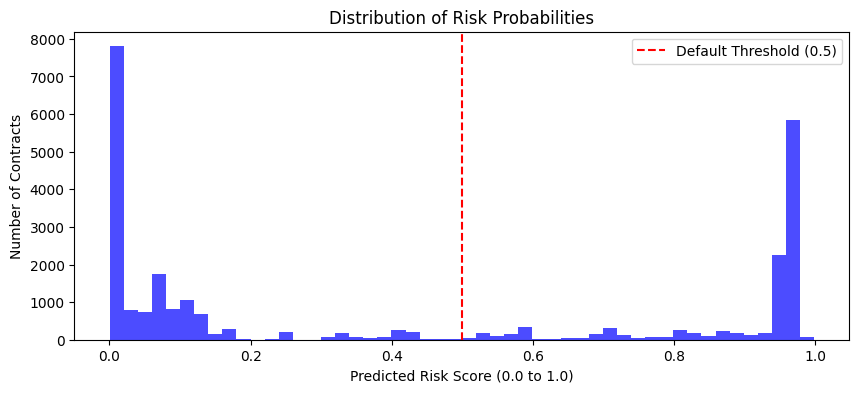

count    26347.000000
mean         0.416972
std          0.429271
min          0.000193
50%          0.121787
75%          0.956743
90%          0.967275
95%          0.967991
99%          0.969762
max          0.998836
dtype: float64

--- 2024 Prediction Results ---
PR AUC Score: 0.0331
              precision    recall  f1-score   support

           0       0.98      0.58      0.73     25747
           1       0.03      0.59      0.06       600

    accuracy                           0.58     26347
   macro avg       0.51      0.59      0.40     26347
weighted avg       0.96      0.58      0.72     26347



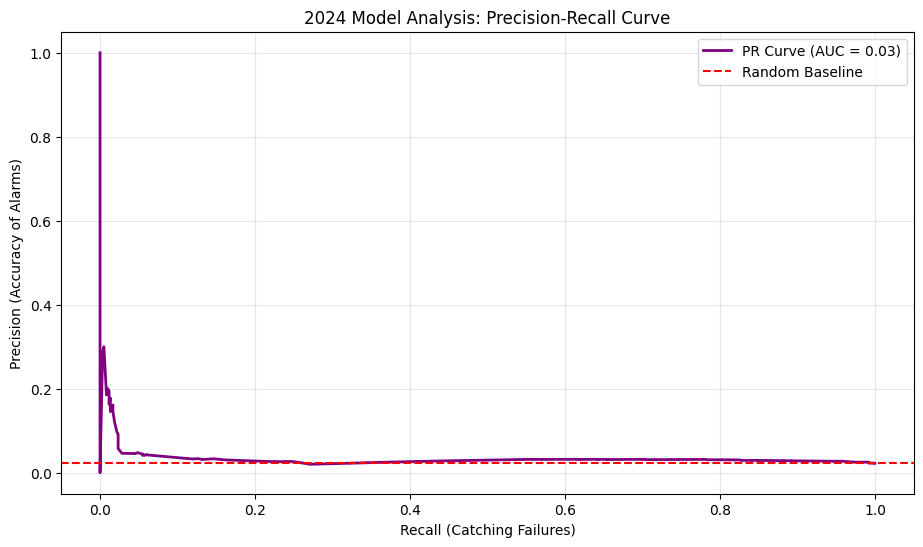


--- What Drove Decisions? ---
                     Feature  Importance
1           buyer_risk_score    0.736079
8    is_Health & Social Work    0.073955
0        tender_value_amount    0.048307
11                  is_Other    0.034580
7   is_Consulting & Business    0.030278
5            is_Construction    0.024163
4           accelerated_flag    0.022943
10              is_Transport    0.013710
9      is_Security & Defense    0.009134
2             lead_time_days    0.006850


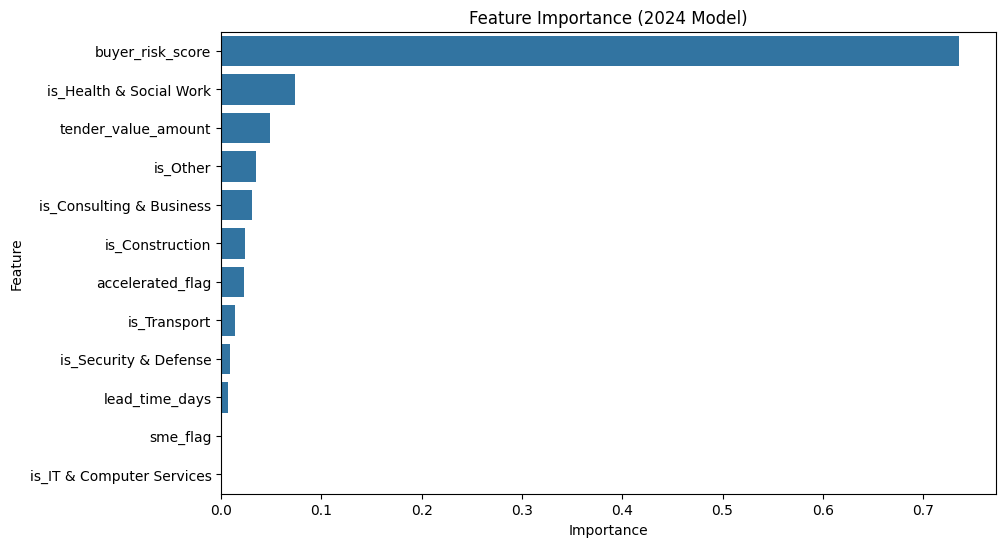

In [10]:
print("Training Weighted XGBoost...")

# 1 - Initialise the model with our penalty (scale_pos_weight)
# 34.4 forces the model to prioritise our rare failures
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=34.4,       
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Train on the pure data
model.fit(X_train, y_train)
print("Model trained successfully.")

# 3 - Predict on 2024 (Wwith the variable threshold)
# We calculate probabilities first so we can apply our own strict rule
y_probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 4))
plt.hist(y_probs, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Risk Probabilities')
plt.xlabel('Predicted Risk Score (0.0 to 1.0)')
plt.ylabel('Number of Contracts')
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.legend()
plt.show()

# grid for the exact percentiles
print(pd.Series(y_probs).describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

# --- This number is variable  (can change) to affect precision ---
CUSTOM_THRESHOLD = 0.5  
# -----------------------------------------------------------------

# Creating hard labels based on the new threshold
y_pred = (y_probs > CUSTOM_THRESHOLD).astype(int)

# 4 - Calculating PR AUC (the metric of quality for imbalanced data)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc_score = auc(recall, precision)

# 5. Show Results
print("\n--- 2024 Prediction Results ---")
print(f"PR AUC Score: {pr_auc_score:.4f}") 
print(classification_report(y_test, y_pred))

# 6 - Precision-Recall Curve
plt.figure(figsize=(11, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc_score:.2f})', color='purple', lw=2)
plt.axhline(y=y_test.mean(), color='red', linestyle='--', label='Random Baseline')
plt.xlabel('Recall (Catching Failures)')
plt.ylabel('Precision (Accuracy of Alarms)')
plt.title('2024 Model Analysis: Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()

# 7 - Show Feature Importance
print("\n--- What Drove Decisions? ---")
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance.head(10))

# 8 - Feature Importance graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance (2024 Model)')
plt.show()

In [11]:
# --- PHASE A: TSandbox Testing ---
from sklearn.utils import resample
from sklearn.metrics import average_precision_score, roc_auc_score

print("--- INITIATING SANDBOX DIAGNOSTIC ---")

# 1 - Isolate the minority (Failures) and majority (Successes) from Training Data
# We use the raw X_train/y_train from the previous split (before any weights)
train_df = X_train.copy()
train_df['Risk_Label'] = y_train

failures = train_df[train_df['Risk_Label'] == 1]
successes = train_df[train_df['Risk_Label'] == 0]

print(f"Original Pool: {len(failures)} Failures vs {len(successes)} Successes")

# 2 - Downsample successes to create an easy ratio (e.g., 1:4 or 20% Risk)
# We keep ALL failures, but only keep 4x as many successes
n_failures = len(failures)
n_keep_success = n_failures * 4 

successes_downsampled = resample(successes, 
                                 replace=False,    # No duplicates
                                 n_samples=n_keep_success, 
                                 random_state=42)  # Reprodicible

# 3 - Combine to create the Sandbox
sandbox_df = pd.concat([failures, successes_downsampled])
X_sandbox = sandbox_df.drop('Risk_Label', axis=1)
y_sandbox = sandbox_df['Risk_Label']

print(f"Sandbox Created: {len(X_sandbox)} rows.")
print(f"Sandbox Ratio: 1 Failure for every 4 Successes (~20% Risk)")

# 4 - Train a Sandbox Model (not using weights here, the data is balanced-ish)
sandbox_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss'
)

sandbox_model.fit(X_sandbox, y_sandbox)
print("Sandbox Model Trained.")

# 5 - Evaluate on the sandbox (did it learn?)
# We test on the training set itself first to see if it can learn
y_sandbox_pred = sandbox_model.predict(X_sandbox)
y_sandbox_prob = sandbox_model.predict_proba(X_sandbox)[:, 1]

# 6 - Evaluate on the 2024 Test Set (real world)
# Does a model trained in a sandbox work in the real world?
y_test_pred = sandbox_model.predict(X_test)
y_test_prob = sandbox_model.predict_proba(X_test)[:, 1]

# -- METRICS REPORT --
print("\n--- Results ---")

# PR-AUC (Precision-Recall Area Under Curve)
# High Score (e.g., >0.5) = The features are good.
# Low Score (e.g., <0.1) = The data is bad.
sandbox_pr_auc = average_precision_score(y_sandbox, y_sandbox_prob)
test_pr_auc = average_precision_score(y_test, y_test_prob)

print(f"Sandbox PR-AUC (The Capability Score): {sandbox_pr_auc:.4f}")
print(f"Real-World PR-AUC (The Difficulty Score): {test_pr_auc:.4f}")

print("\n--- Confusion Matrix (Real World) ---")
print(classification_report(y_test, y_test_pred))

--- INITIATING SANDBOX DIAGNOSTIC ---
Original Pool: 1185 Failures vs 47382 Successes
Sandbox Created: 5925 rows.
Sandbox Ratio: 1 Failure for every 4 Successes (~20% Risk)
Sandbox Model Trained.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:14:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Results ---
Sandbox PR-AUC (The Capability Score): 0.8785
Real-World PR-AUC (The Difficulty Score): 0.0309

--- Confusion Matrix (Real World) ---
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     25747
           1       0.03      0.48      0.05       600

    accuracy                           0.62     26347
   macro avg       0.50      0.55      0.41     26347
weighted avg       0.96      0.62      0.75     26347



Training Model A (2022-23)...
Training Model B (2021-23)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:17:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:17:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



METRIC                    | MODEL A (22-23) | MODEL B (21-23)
Recall (Safety)           | 0.59            | 0.58
Precision (Noise)         | 0.03            | 0.03
Accuracy                  | 0.58            | 0.58
Contracts Flagged         | 11072            | 11058


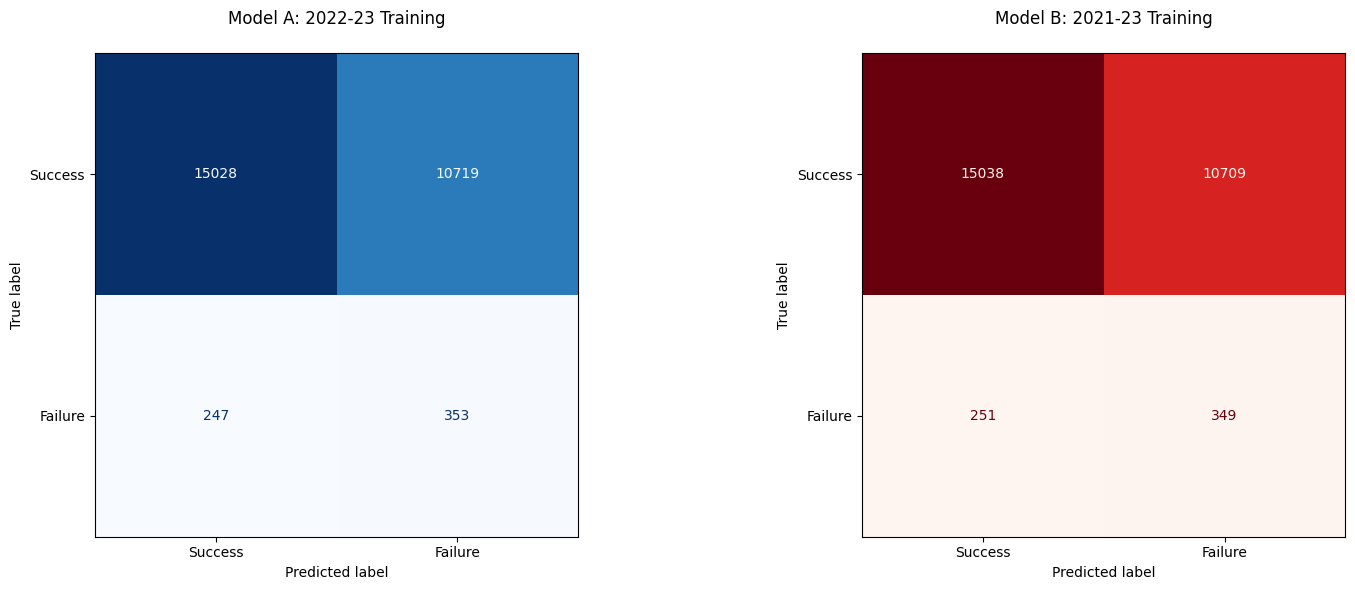

In [15]:
# -- CONFIG 1: (Standard / Clean) --
# 1 - Combining the raw data first
raw_clean = pd.concat([df_22, df_23], ignore_index=True)   

# 2 - Extract target (y) BEFORE filtering features
y_train_clean = raw_clean['Risk_Label']

# 3 - Extract Features (X).
X_train_clean = raw_clean.reindex(columns=features, fill_value=0).fillna(0)

# 4 - Train
print("Training Model A (2022-23)...")
model_clean = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=34.4,       
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = model_clean.predict(X_test)


# -- CONFIG 2: (Noisy) --
# 1. Combine the Raw Data first (Including 2021).
raw_noisy = pd.concat([df_21, df_22, df_23], ignore_index=True)

# 2. Extract target (y) BEFORE filtering features
y_train_noisy = raw_noisy['Risk_Label']

# 3. Extract Features (X)
X_train_noisy = raw_noisy.reindex(columns=features, fill_value=0).fillna(0)

# 4. Train
print("Training Model B (2021-23)...")
model_noisy = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=34.4,       
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_noisy.fit(X_train_noisy, y_train_noisy)
y_pred_noisy = model_noisy.predict(X_test)


# -- STEP 3: THE SIDE BY SIDE TABLE --
print("\n" + "="*65)
print(f"{'METRIC':<25} | {'MODEL A (22-23)':<15} | {'MODEL B (21-23)':<15}")
print("="*65)
print(f"{'Recall (Safety)':<25} | {recall_score(y_test, y_pred_clean):.2f}{'':<11} | {recall_score(y_test, y_pred_noisy):.2f}")
print(f"{'Precision (Noise)':<25} | {precision_score(y_test, y_pred_clean):.2f}{'':<11} | {precision_score(y_test, y_pred_noisy):.2f}")
print(f"{'Accuracy':<25} | {accuracy_score(y_test, y_pred_clean):.2f}{'':<11} | {accuracy_score(y_test, y_pred_noisy):.2f}")
print(f"{'Contracts Flagged':<25} | {sum(y_pred_clean)}{'':<11} | {sum(y_pred_noisy)}")
print("="*65)

# -- STEP 4: Comparing confusion matrices --
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Model A (Clean)
cm_clean = confusion_matrix(y_test, y_pred_clean)
disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean, display_labels=['Success', 'Failure'])
disp_clean.plot(cmap='Blues', ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title('Model A: 2022-23 Training\n')

# Plot Model B (Noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)
disp_noisy = ConfusionMatrixDisplay(confusion_matrix=cm_noisy, display_labels=['Success', 'Failure'])
disp_noisy.plot(cmap='Reds', ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title('Model B: 2021-23 Training\n')

plt.tight_layout()
plt.show()

In [13]:
#print(f"2021 Data Size: {len(df_21)}")
print(f"2022 Data Size: {len(df_22)}")
print(f"2023 Data Size: {len(df_23)}")

print(f"\nModel A Training Rows: {len(X_train_clean)}")
print(f"Model B Training Rows: {len(X_train_noisy)}")

# If Model B has ~15,000 more rows than Model A, the test is valid.

2022 Data Size: 24477
2023 Data Size: 24090

Model A Training Rows: 48567
Model B Training Rows: 70192
